<a href="https://www.kaggle.com/code/dalloliogm/blend-of-top-4-public-solutions-multiple-strateg?scriptVersionId=246487250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Blend of top solutions


This notebook is based on the amazing notebook https://www.kaggle.com/code/nina2025/blend-of-top-3-public-solutions . Thanks for sharing it!

I've added a few additional strategies for combining the submissions.

# Update

Based the notebook on this one instead: https://www.kaggle.com/code/nina2025/ensemble-of-top-4-public-solutions Thanks @nina2025 for sharing it!



In [1]:
import pandas as pd
from collections import Counter

# Load new predictions
path = '/kaggle/input/19-june-2025-fertilizer/'

# Define model names based on filenames
file_map = {
    'LB_0': 'LB__0_37_474',
    'LB_1': 'LB__0_37_631',
    'LB_2': 'LB__0_37_780',
    'LB_3': 'LB__0_37_856',
    'GEN_1': 'LB__0_GEN_1',
    'GEN_2': 'LB__0_GEN_2',
    'GEN_3': 'LB__0_GEN_3',
    'GEN_4': 'LB__0_GEN_4',
    'GEN_5': 'LB__0_GEN_5',
}


In [2]:
# Read and rename
dfs = []
for name, fname in file_map.items():
    df = pd.read_csv(path + f'submission__{fname}.csv')
    df = df.rename(columns={'Fertilizer Name': name})
    dfs.append(df)

# Merge all on 'id'
from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on='id'), dfs)
df_merged.head()

,id,LB_0,LB_1,LB_2,LB_3,GEN_1,GEN_2,GEN_3,GEN_4,GEN_5
0,750000,10-26-26 20-20 14-35-14,10-26-26 DAP 20-20,10-26-26 DAP 20-20,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP
1,750001,17-17-17 10-26-26 28-28,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea
2,750002,Urea 20-20 DAP,20-20 Urea DAP,20-20 Urea DAP,Urea 20-20 DAP,20-20 Urea DAP,20-20 Urea DAP,20-20 Urea DAP,20-20 Urea DAP,20-20 Urea DAP
3,750003,14-35-14 DAP 10-26-26,14-35-14 17-17-17 DAP,14-35-14 17-17-17 DAP,14-35-14 Urea 10-26-26,14-35-14 DAP 17-17-17,14-35-14 Urea 10-26-26,14-35-14 DAP 17-17-17,14-35-14 DAP 17-17-17,14-35-14 DAP 17-17-17
4,750004,20-20 Urea 17-17-17,Urea 20-20 17-17-17,Urea 20-20 10-26-26,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17


In [3]:

# Utility function
def get_top3(row, method='vote', weights=None):
    preds = [row[name] for name in file_map.keys()]
    if method == 'vote':
        return ' '.join([x for x, _ in Counter(preds).most_common(3)])

    elif method == 'weighted':
        score_map = {}
        for name in file_map.keys():
            label = row[name]
            score_map[label] = score_map.get(label, 0) + weights.get(name, 1.0)
        sorted_preds = sorted(score_map.items(), key=lambda x: -x[1])
        seen, result = set(), []
        for label, _ in sorted_preds:
            if label not in seen:
                result.append(label)
                seen.add(label)
            if len(result) == 3:
                break
        return ' '.join(result)

    elif method == 'consensus_fill':
        counts = Counter(preds)
        common = [x for x, c in counts.items() if c > 1]
        rest = [x for x in preds if x not in common]
        final = common + [x for x in rest if x not in common]
        return ' '.join(dict.fromkeys(final))[:3]

    elif method == 'stacked':
        return ' '.join(dict.fromkeys(preds))[:3]

    elif method == 'diverse':
        return ' '.join(dict.fromkeys(preds))[:3]

    else:
        raise ValueError("Unknown method")

# Define weights manually or based on LB (optional guess)
weights = {
    'LB_0': 0.92,
    'LB_1': 0.89,
    'LB_2': 0.88,
    'LB_3': 0.85,
    'GEN_1': 0.80,
    'GEN_2': 0.78,
    'GEN_3': 0.76,
    'GEN_4': 0.75,
    'GEN_5': 0.74
}

# Run ensemble and export multiple versions
methods = ['vote', 'weighted', 'consensus_fill', 'stacked', 'diverse']

for method in methods:
    df_merged['Fertilizer Name'] = df_merged.apply(get_top3, axis=1, method=method, weights=weights)
    sub = df_merged[['id', 'Fertilizer Name']]
    sub.to_csv(f'ensemble_{method}.csv', index=False)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


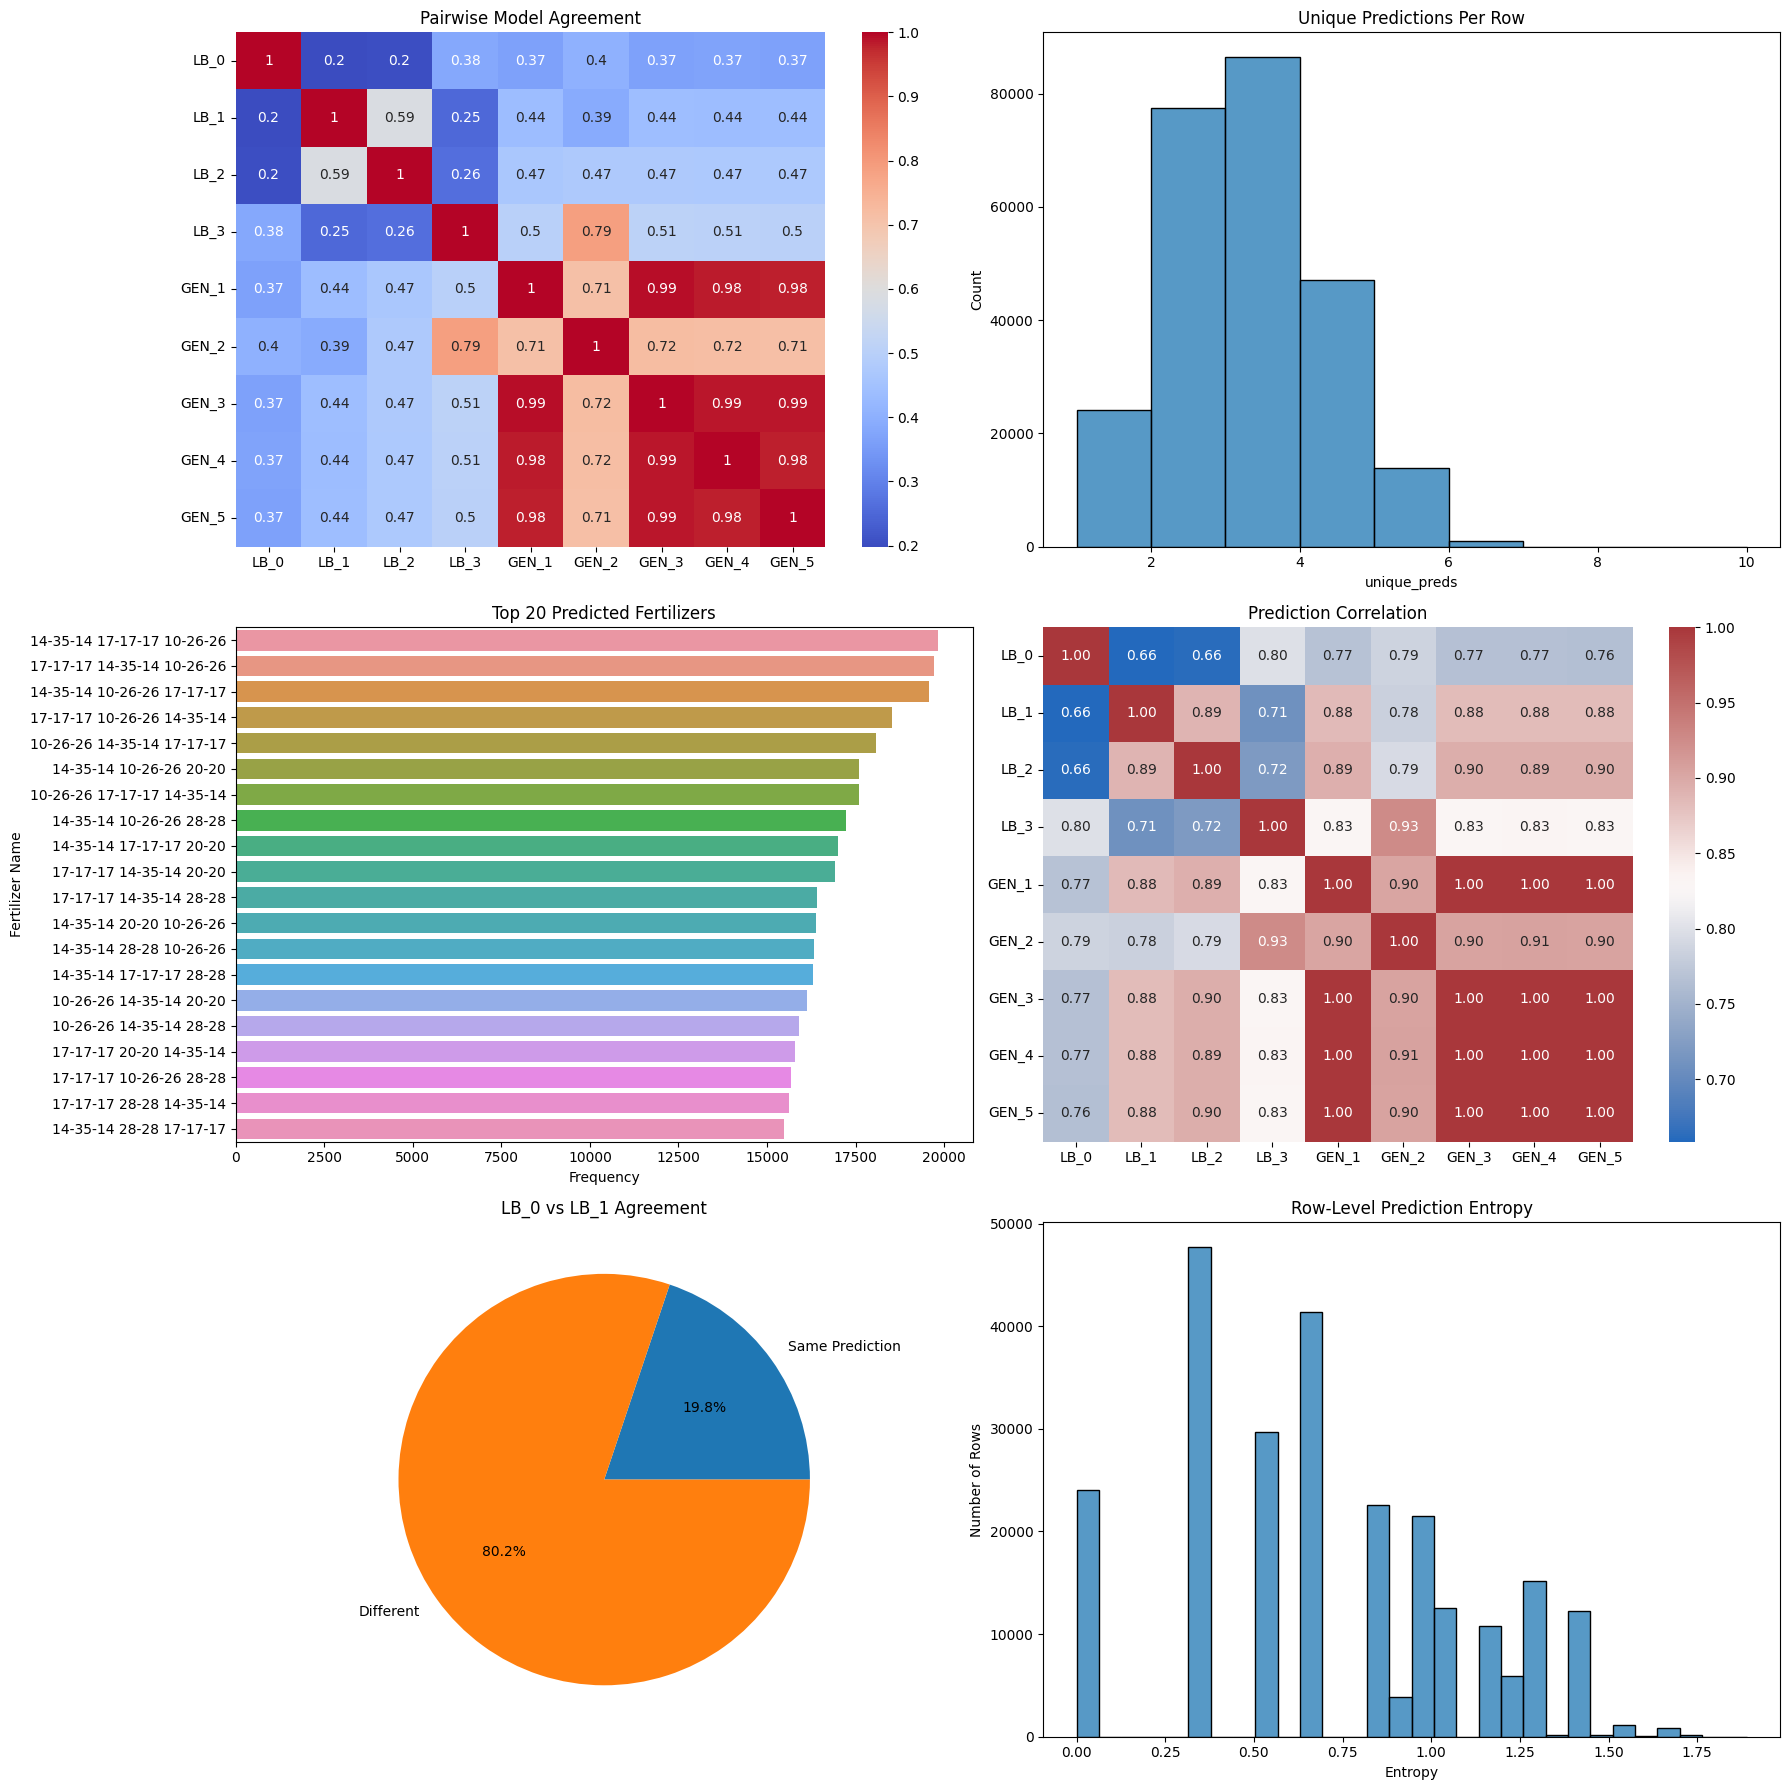

In [4]:
from scipy.stats import entropy
import seaborn as sns
import matplotlib.pyplot as plt

# Compute entropy per row based on prediction diversity
def row_entropy(row):
    counts = Counter(row)
    probs = [v / len(row) for v in counts.values()]
    return entropy(probs)

def compute_agreement(df, model_cols):
    n = len(model_cols)
    agreement_matrix = pd.DataFrame(0, index=model_cols, columns=model_cols)
    for i in range(n):
        for j in range(i, n):
            same = (df[model_cols[i]] == df[model_cols[j]]).sum()
            agreement_matrix.iloc[i, j] = same
            agreement_matrix.iloc[j, i] = same
    agreement_matrix = agreement_matrix / len(df)
    return agreement_matrix

agreement = compute_agreement(df_merged, list(file_map.keys()))


df_merged['row_entropy'] = df_merged[list(file_map.keys())].apply(row_entropy, axis=1)

# Plot in axes[2, 1]
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Recreate previous plots
sns.heatmap(compute_agreement(df_merged, list(file_map.keys())), annot=True, cmap='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Pairwise Model Agreement')

df_merged['unique_preds'] = df_merged[list(file_map.keys())].apply(lambda row: len(set(row)), axis=1)
sns.histplot(df_merged['unique_preds'], bins=range(1, len(file_map)+2), ax=axes[0, 1])
axes[0, 1].set_title('Unique Predictions Per Row')

fertilizer_counts = pd.concat([df_merged[col] for col in file_map.keys()]).value_counts().head(20)
fertilizer_df = fertilizer_counts.reset_index()
fertilizer_df.columns = ['Fertilizer Name', 'Frequency']
sns.barplot(data=fertilizer_df, x='Frequency', y='Fertilizer Name', ax=axes[1, 0])
axes[1, 0].set_title('Top 20 Predicted Fertilizers')

binary_df = pd.DataFrame({name: df_merged[name].astype("category").cat.codes for name in file_map})
sns.heatmap(binary_df.corr(), annot=True, cmap='vlag', fmt=".2f", ax=axes[1, 1])
axes[1, 1].set_title('Prediction Correlation')

overlap = df_merged[df_merged['LB_0'] == df_merged['LB_1']]
overlap_counts = [len(overlap), len(df_merged) - len(overlap)]
axes[2, 0].pie(overlap_counts, labels=['Same Prediction', 'Different'], autopct='%1.1f%%')
axes[2, 0].set_title('LB_0 vs LB_1 Agreement')

# NEW: Row entropy
sns.histplot(df_merged['row_entropy'], bins=30, ax=axes[2, 1])
axes[2, 1].set_title('Row-Level Prediction Entropy')
axes[2, 1].set_xlabel('Entropy')
axes[2, 1].set_ylabel('Number of Rows')

plt.tight_layout()
plt.show()


In [5]:
df_merged

,id,LB_0,LB_1,LB_2,LB_3,GEN_1,GEN_2,GEN_3,GEN_4,GEN_5,Fertilizer Name,row_entropy,unique_preds
0,750000,10-26-26 20-20 14-35-14,10-26-26 DAP 20-20,10-26-26 DAP 20-20,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-26-26 20-20 DAP,10-,0.848686,3
1,750001,17-17-17 10-26-26 28-28,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-17-17 10-26-26 Urea,17-,0.348832,2
2,750002,Urea 20-20 DAP,20-20 Urea DAP,20-20 Urea DAP,Urea 20-20 DAP,20-20 Urea DAP,20-20 Urea DAP,20-20 Urea DAP,20-20 Urea DAP,20-20 Urea DAP,Ure,0.529706,2
3,750003,14-35-14 DAP 10-26-26,14-35-14 17-17-17 DAP,14-35-14 17-17-17 DAP,14-35-14 Urea 10-26-26,14-35-14 DAP 17-17-17,14-35-14 Urea 10-26-26,14-35-14 DAP 17-17-17,14-35-14 DAP 17-17-17,14-35-14 DAP 17-17-17,14-,1.273028,4
4,750004,20-20 Urea 17-17-17,Urea 20-20 17-17-17,Urea 20-20 10-26-26,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17,Urea 20-20 17-17-17,20-,0.683739,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Urea 14-35-14 17-17-17,Urea 17-17-17 14-35-14,Urea 14-35-14 17-17-17,Urea 14-35-14 17-17-17,Urea 14-35-14 17-17-17,Urea 14-35-14 17-17-17,Urea 14-35-14 17-17-17,Urea 14-35-14 17-17-17,Urea 14-35-14 17-17-17,Ure,0.348832,2
249996,999996,14-35-14 17-17-17 Urea,14-35-14 10-26-26 28-28,28-28 14-35-14 10-26-26,14-35-14 28-28 Urea,14-35-14 28-28 10-26-26,14-35-14 28-28 Urea,14-35-14 28-28 10-26-26,14-35-14 28-28 10-26-26,14-35-14 28-28 10-26-26,14-,1.427061,5
249997,999997,Urea 10-26-26 DAP,Urea 10-26-26 20-20,Urea 10-26-26 DAP,Urea 10-26-26 DAP,Urea 10-26-26 DAP,Urea 10-26-26 DAP,Urea 10-26-26 DAP,Urea 10-26-26 DAP,Urea 10-26-26 DAP,Ure,0.348832,2
249998,999998,10-26-26 17-17-17 Urea,10-26-26 17-17-17 DAP,10-26-26 17-17-17 DAP,10-26-26 17-17-17 DAP,10-26-26 17-17-17 DAP,10-26-26 17-17-17 DAP,10-26-26 17-17-17 DAP,10-26-26 17-17-17 DAP,10-26-26 17-17-17 DAP,10-,0.348832,2
